In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sherpa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from tqdm.notebook import tqdm
from torchviz import make_dot

import logging 
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logger.info("IS_CRITICAL uuuhh")

torch.__version__

'1.4.0a0+fe76af9'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#path = "drive/My Drive/AML/"
path = ""

df = pd.read_csv(path + "pmsm_temperature_data.csv")

In [4]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                                axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                                axis=1).max()

df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [5]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7, 8, 9, 10]

def dataloader(data, length, shuffle=True, out=1):
    while True:
    # genera una lista di (i_serie, i_obs)
        tuples = [[(df_i, i) for i, x in enumerate(data[df_i]) if i >= length + out]
                  for df_i, _ in enumerate(data)]
        tuples = sum(tuples, [])  # flattenizza
        # shuffle
        if shuffle:
            np.random.shuffle(tuples)

        # yielda le osservazioni
        for df_i, i in tuples:
            X_lagged = data[df_i][(i - length - out):(i - out + 1), FEATURES]
            y = data[df_i][(i-out):(i), TARGET]
            yield X_lagged, y
            

def new_loss(w1=1, w2=1):
    "w1 is the weight for lower temperature and w2 for the upper So w1 <= w2"
    def high_low_loss(output, target):
        weights = w1 + (w2 - w1)*F.relu(target - 0.5)
        return torch.mean(weights*((output - target)**2))
    
    return high_low_loss

In [6]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

class Reg_CNN_Net(nn.Module):
    def __init__(self, features, seq_len, 
                 conv1, conv2, kernel1, kernel2,
                 h1, h2, out):
        super(Reg_CNN_Net, self).__init__()
        #self.h1 = h1
        self.h2 = h2
        #self.conv1 = conv1
        self.conv2 = conv2

        self.features = features
        self.seq_len = seq_len
        
        self.c1 = nn.Conv1d(self.features, conv1, kernel1)
        
        h0 = outputSize(self.seq_len, kernel1, 1, 0)*conv1
        if conv2 != 0:
            self.c2 = nn.Conv1d(conv1, conv2, kernel2)
        
        
            h0 = outputSize(outputSize(self.seq_len, kernel1, 1, 0), 
                            kernel2, 1 ,0)*conv2

        self.fc1 = nn.Linear(h0, h1)
        

        if self.h2 != 0:
            self.fc2 = nn.Linear(h1, h2)
            
            self.out = nn.Linear(h2, out)
        else:
            self.out = nn.Linear(h1, out)

    def forward(self, x):
        batch_size, _, _ = x.shape 
        
        x1 = F.tanh(self.c1(x))
        if self.conv2!=0:
            x = F.tanh(self.c2(x1))
        else:
            x = x1
        
        x = x.view(batch_size,-1)
        
        x = F.relu(self.fc1(x))
        if self.h2 != 0:
            x = F.relu(self.fc2(x))
        return self.out(x)

In [18]:
parameters = [sherpa.Continuous('lr',[0.001,0.01]),
              sherpa.Discrete('conv1',[2,7]),
              sherpa.Discrete('conv2',[0,7]),
              sherpa.Discrete('kernel1',[2,5]),
              sherpa.Discrete('kernel2',[2,5]),
              sherpa.Discrete('h1',[16,64]),
              sherpa.Discrete('h2',[0,64]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [19]:
look_back  = 20
best_score = 99999
feature    = 7


def customLoss(w1=1, w2=1):
    "w1 is the weight for lower temperature and w2 for the upper So w1 <= w2"
    def high_low_loss(output, target):
        weights = w1 + (w2 - w1) * F.relu(target - 0.5)
        return torch.mean(weights * ((output - target)**2))

    return high_low_loss

for trial in study:

    cnn = Reg_CNN_Net(features=feature, seq_len=look_back+1,
                     conv1 = int(trial.parameters["conv1"]),
                     conv2 = int(trial.parameters["conv2"]),
                     kernel1 = int(trial.parameters["kernel1"]),
                     kernel2 = int(trial.parameters["kernel2"]),
                     h1=int(trial.parameters["h1"]),
                     h2=int(trial.parameters["h2"]), out=4).to(device)
                     
    losses = []
    #just change here and you should get the other loss
    #criterion = customLoss(1,3)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=trial.parameters["lr"],
                                weight_decay=0.001)

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    cnn.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(np.swapaxes(X,0,1))
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, feature, look_back + 1)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = cnn(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  
            
            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except Exception as e:
            print("This Happened happened", e)
            print(inpt.shape)
            print(x_batch.size())
            break
        
    
    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    cnn.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(np.swapaxes(X,0,1))
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, feature, look_back + 1)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = cnn(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    
    score = np.mean(criterion(torch.from_numpy(y_pred_all), 
                      torch.from_numpy(y_test)).numpy())
    #score = np.mean((y_pred_all - y_test)**2)
    if trial.id % 10 == 0:
        print("Now at Trial",trial.id)
    if score < best_score:
        best_score = score
        torch.save(cnn, path + "models/best_model_cnn_reg_new")
        print("ID:", trial.id,"New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN_reg_new.csv")

ID: 1 New Challanger with MSE on val: 0.04234328402595791 and confs: {'lr': 0.001638576350663314, 'conv1': 2, 'conv2': 4, 'kernel1': 2, 'kernel2': 2, 'h1': 54, 'h2': 45, 'batch_size': 2048}
Now at Trial 10
Now at Trial 20
ID: 22 New Challanger with MSE on val: 0.04024965880353362 and confs: {'lr': 0.0055073544022206785, 'conv1': 2.0, 'conv2': 3.0, 'kernel1': 2.0, 'kernel2': 2.0, 'h1': 55.0, 'h2': 46.0, 'batch_size': 512.0}
Now at Trial 30
Now at Trial 40
Now at Trial 50
Now at Trial 60
Now at Trial 70
Now at Trial 80
Now at Trial 90
Now at Trial 100


In [20]:
best_model = torch.load(path + "models/best_model_cnn_reg_new")
results = pd.read_csv(path + "results/AutoML_CNN_reg_new.csv")
results = results[results["Status"]=="COMPLETED"]

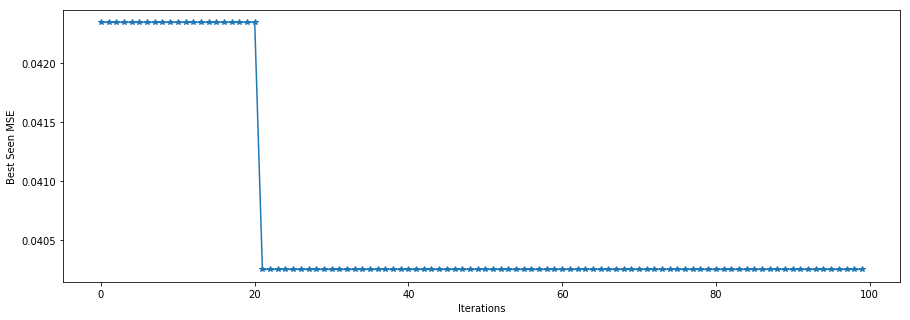

In [21]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [22]:
test_n = 1
look_back = 20

test_gen = dataloader([df_test[test_n].values], look_back, shuffle=False)
size = df_test[test_n].shape[0]

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, 7, look_back + 1)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

y_test = np.array(y_test).reshape(-1,4)
y_pred_all = y_pred_all.reshape(-1,4)

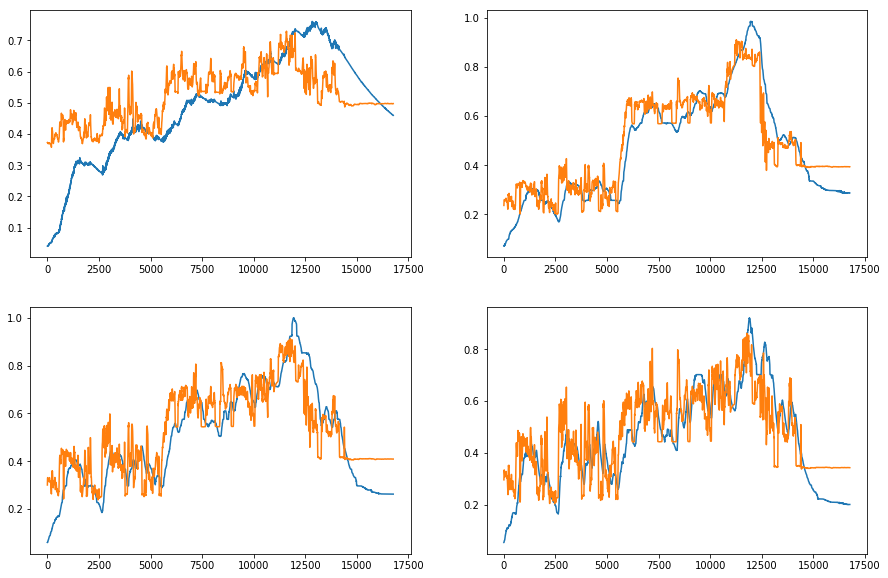

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(y_test[:size - look_back - 1,0])
plt.plot(y_pred_all[:size - look_back - 1,0])

plt.subplot(222)
plt.plot(y_test[:size - look_back - 1,1])
plt.plot(y_pred_all[:size - look_back - 1,1])

plt.subplot(223)
plt.plot(y_test[:size - look_back - 1,2])
plt.plot(y_pred_all[:size - look_back - 1,2])

plt.subplot(224)
plt.plot(y_test[:size - look_back - 1,3])
plt.plot(y_pred_all[:size - look_back - 1,3])
plt.show()


plt.show()

In [24]:
np.mean((y_test - y_pred_all)**2)

0.012134627959096797

In [17]:
best_model

Reg_CNN_Net(
  (c1): Conv1d(7, 6, kernel_size=(4,), stride=(1,))
  (c2): Conv1d(6, 2, kernel_size=(6,), stride=(1,))
  (fc1): Linear(in_features=26, out_features=57, bias=True)
  (fc2): Linear(in_features=57, out_features=37, bias=True)
  (out): Linear(in_features=37, out_features=4, bias=True)
)

In [128]:
best_model = torch.load(path + "models/best_model_cnn_reg_new_c_loss")
results = pd.read_csv(path + "results/AutoML_CNN_reg_new_c_loss.csv")
results = results[results["Status"]=="COMPLETED"]

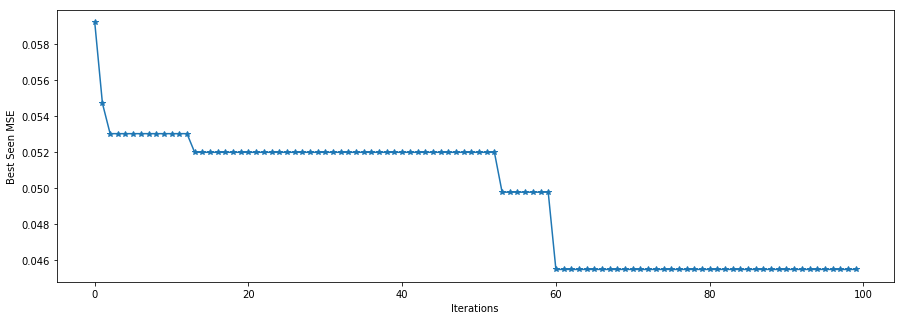

In [129]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [130]:
test_n = 1
look_back = 20

test_gen = dataloader([df_test[test_n].values], look_back, shuffle=False)
size = df_test[test_n].shape[0]

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, 7, look_back + 1)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

y_test = np.array(y_test).reshape(-1,4)
y_pred_all = y_pred_all.reshape(-1,4)

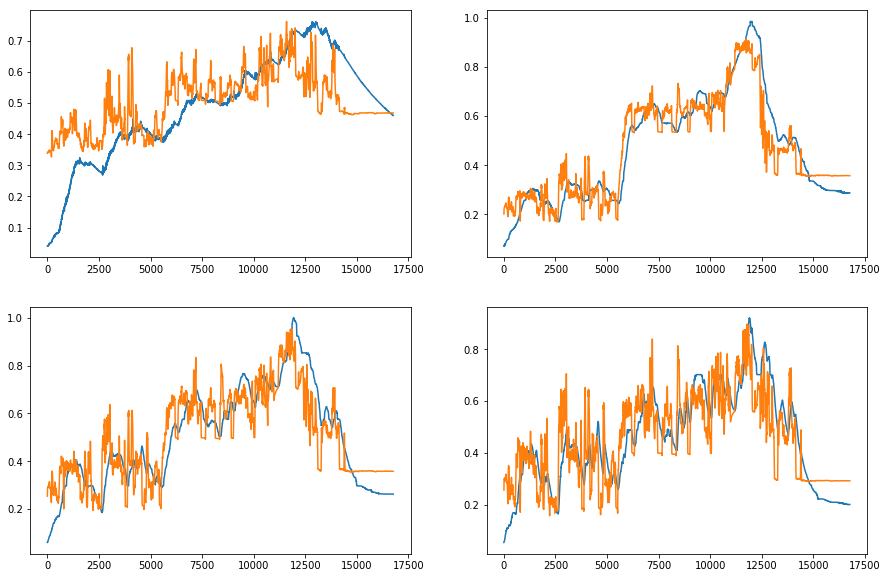

In [131]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(y_test[:size - look_back - 1,0])
plt.plot(y_pred_all[:size - look_back - 1,0])

plt.subplot(222)
plt.plot(y_test[:size - look_back - 1,1])
plt.plot(y_pred_all[:size - look_back - 1,1])

plt.subplot(223)
plt.plot(y_test[:size - look_back - 1,2])
plt.plot(y_pred_all[:size - look_back - 1,2])

plt.subplot(224)
plt.plot(y_test[:size - look_back - 1,3])
plt.plot(y_pred_all[:size - look_back - 1,3])
plt.show()


plt.show()

In [132]:
np.mean((y_pred_all - y_test)**2)

0.011540125768136409

In [133]:
best_model

Reg_CNN_Net(
  (c1): Conv1d(7, 5, kernel_size=(2,), stride=(1,))
  (c2): Conv1d(5, 7, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=133, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=4, bias=True)
)